Download torch and torchvision

In [1]:
# pip install torch
# pip install timm

In [2]:
# pip install torchvision

Initialization

In [ ]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler, Dataset, DataLoader, SubsetRandomSampler
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import pandas as pd
import numpy as np

USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [ ]:
# data augmentation
transform = v2.Compose([
                v2.ToImage(), 
                v2.Resize((224, 224)), 
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.5]*3, std=[0.5]*3), 
                
                # v2.RandomHorizontalFlip(),
                v2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.3, 0.3)),
                # v2.RandomChannelPermutation(),
                # v2.RandomErasing(p=0.5, scale=(0.05, 0.3), ratio=(1, 1), value='random'),
                v2.RandomRotation(degrees=10)])

In [ ]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [ ]:
# creat a dictionary that maps index to label
data_dir='ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [ ]:
button_train = CropButtonDataset('ClassificationDataset_label/train', transform=transform)
loader_train = DataLoader(button_train, batch_size=64, shuffle=True)

button_val = CropButtonDataset('ClassificationDataset_label/val', transform=transform)
loader_val = DataLoader(button_val, batch_size=14, shuffle=True)

button_test = CropButtonDataset('ClassificationDataset_label/test', transform=transform)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [ ]:
loader_train

In [ ]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([14, 3, 224, 224])
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0])


Model setup

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
def check_accuracy_final(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype).unsqueeze(1)
            scores = model(x)
            preds = (torch.sigmoid(scores) > 0.5).long()

            # print("Sample preds:", preds[:10].flatten().tolist())
            
            num_correct += (preds == y.long()).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

def train(model, optimizer, epochs=10):
    x1 = list(range(len(loader_train) * epochs))
    x2 = []
    y1 = []
    y2 = []
    model = model.to(device=device)
    criterion = nn.BCEWithLogitsLoss()
    cnt = 0
    total_cnt = epochs * len(loader_train)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype).unsqueeze(1)

            scores = model(x)
            loss = criterion(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y1.append(loss.item())

            print("iteration: " +  str(cnt) + "/" + str(total_cnt) + ": loss = " + str(loss.item()))
            if cnt % 1 == 0:
                acc_val = check_accuracy_final(loader_val, model)
                print("val_acc = " + str(acc_val))
                acc_train = check_accuracy_final(loader_train, model)
                print("train_acc = " + str(acc_train))
                x2.append(cnt)
                y2.append(acc_val)

            cnt += 1
    return (x1, y1, x2, y2)

def plotpic(data):
  x1, y1, x2, y2 = data
  plt.figure()
  plt.plot(x1, y1, marker='.')
  plt.xlabel('Iteratoin')
  plt.ylabel('Loss')
  plt.title('Loss')
  plt.grid(True)

  plt.figure()
  plt.plot(x2, y2, marker='o')
  plt.xlabel('Iteratoin')
  plt.ylabel('Val Acc')
  plt.title('Val Acc')
  plt.grid(True)
  plt.show()

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

vit_output_dim = model.head.out_features 

model.head = nn.Sequential(
    model.head,
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(vit_output_dim, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1)
)

model = model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
sgdMNb = optim.SGD(model.parameters(), lr=1e-2,
                     momentum=0.8, nesterov=True)
adamw = optim.AdamW(model.parameters(), lr=5e-6,
                        weight_decay=3e-2)

Train

In [ ]:
data = train(model, adamw, epochs=10)

iteration: 0/100: loss = 0.7333539724349976
val_acc = 0.5
train_acc = 0.5041322314049587
iteration: 1/100: loss = 0.7192313075065613
val_acc = 0.42857142857142855
train_acc = 0.512396694214876
iteration: 2/100: loss = 0.7046948075294495
val_acc = 0.5
train_acc = 0.5289256198347108
iteration: 3/100: loss = 0.7458263039588928
val_acc = 0.5
train_acc = 0.5206611570247934
iteration: 4/100: loss = 0.7334305644035339
val_acc = 0.5
train_acc = 0.5289256198347108
iteration: 5/100: loss = 0.7403110265731812
val_acc = 0.42857142857142855
train_acc = 0.512396694214876
iteration: 6/100: loss = 0.7264386415481567
val_acc = 0.5
train_acc = 0.49586776859504134
iteration: 7/100: loss = 0.618163526058197
val_acc = 0.5
train_acc = 0.5206611570247934
iteration: 8/100: loss = 0.7005748748779297
val_acc = 0.42857142857142855
train_acc = 0.5041322314049587
iteration: 9/100: loss = 0.678605854511261
val_acc = 0.5
train_acc = 0.5289256198347108
iteration: 10/100: loss = 0.7479192018508911
val_acc = 0.42857142

In [ ]:
# from itertools import product
# lr = 10 ** np.random.uniform(-3, -6, (10,))
# mm = np.random.uniform(0.8, 0.99, (10,))
# for l, m in product(lr, mm):
#     sgdMNb = optim.SGD(model.parameters(), lr=l,
#                      momentum=m, nesterov=True)
#     data = train(model, sgdMNb, epochs=10)

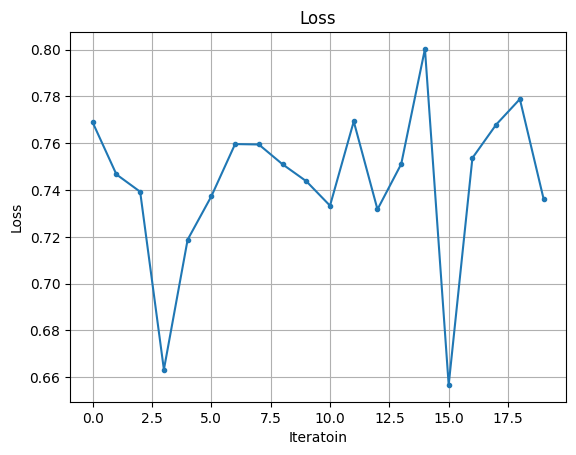

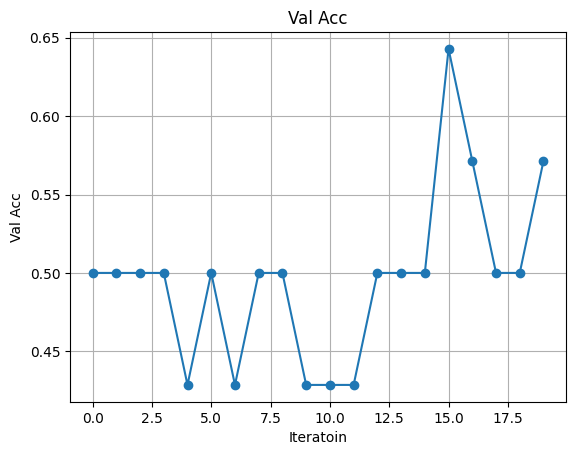

In [ ]:
plotpic(data)